In [7]:
from A440_Standard import FreqDict
from A440_Standard import FreqList
import wave
from bisect import bisect_left
import scipy.stats
from scipy import signal
from scipy.fftpack import fft,ifft
import numpy as np
import math
import pylab as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
import IPython.display as ipd
import sys
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Detect the top n common frequencies in the signal.
def detect_frequency(filename, num=1, chunkSize = 2048):
    sig = wave.open(filename, 'rb')
    sampleWidth= sig.getsampwidth()
    frameRate = sig.getframerate() 
    frequencies = []
    frequenciesInt = []
    frequency = -1
    window = np.blackman(chunkSize*2) # Window should be double chunk size because values are interpolated.
    chunk = sig.readframes(chunkSize) # Break the data into pieces in line with the window.
    # Go through the signal chunk-by-chunk.
    while (len(chunk) > chunkSize * sampleWidth) and (len(chunk) % chunkSize * sampleWidth == 0):
        data = np.array(wave.struct.unpack('%dh' % (len(chunk)/sampleWidth), chunk))*window
        # Take the square of the real fft because we only care about reals.
        fftVals = abs(np.fft.rfft(data))**2
        # Find the peak and then use quadratic interpolation to pull out the frequency unless we're just pulling out an endpiece.
        maximum = fftVals[1:].argmax() + 1
        if maximum != len(fftVals) - 1:
            a, b, c = np.log(fftVals[maximum-1:maximum+2:])
            interp = (c - a) * .5 / (2 * b - c - a)
            frequency = ((maximum + interp) * frameRate) / (chunkSize * 2)
        else:
            frequency = (maximum * frameRate) / chunkSize
        if frequency > 0 and frequency < 20000: # Frequencies that human can hear.
            frequencies.append(frequency)
            frequenciesInt.append(int(round(frequency)))
        chunk = sig.readframes(chunkSize) # Go to next chunk.
    chord = []
    for i in range(num*num):
        frequency = scipy.stats.mode(frequenciesInt) # grab the most common of the frequencies.
        chord.append(frequency[0])
        frequenciesInt = [f for f in frequenciesInt if f != chord[i]]
    return chord

# Determine the notes in the chord according to the A440 standard.
def specify_chord(chord, n):
    cur = 0
    notes = []
    find_closest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
    for f in chord:
        closestFrequency = find_closest(f, FreqList)
        note = FreqDict[closestFrequency]
        if note in notes:
            continue
        else:
            notes.append(note)
            cur += 1
            if cur == n:
                break
    return notes

def plot_the_chord(filename, notes):
    sig = wave.open(filename,"rb")
    params = sig.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    strData  = sig.readframes(nframes)
    sig.close()
    wave_data = np.fromstring(strData,dtype=np.int16)
    wave_data = wave_data*1.0 / (max(abs(wave_data)))
    time=np.arange(0,nframes)/framerate
    xs = wave_data [:nframes]
    xf= np.fft.fft(xs)
    freqs = np.fft.fftfreq(nframes,1.0/framerate)
    # plot the signal in time domain
    plt.figure()
    plt.plot(time/2, xs)
    plt.title("Time Domain")
    plt.ylabel('Signal')
    plt.xlabel('Time [sec]')
    plt.show()
    # plot the signal in frequency domain
    plt.figure()
    fx = freqs[freqs>0]
    fy = np.abs(xf)[freqs>0]
    maxfreq = 0 # to help decide the ceil of freq axis
    for n in notes:
        temp = list(FreqDict.keys())[list(FreqDict.values()).index(n)]
        if maxfreq < list(FreqDict.keys())[list(FreqDict.values()).index(n)]:
            maxfreq = temp
    ceil = math.ceil(maxfreq) // 1000  + 1000
    plt.plot(fx[fx < ceil],fy[fx < ceil]) 
    plt.title("Frequency Domain")
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency [hz]')
    plt.show()
    # plot the spectrum
    plt.figure()
    f, t, Sxx = signal.spectrogram(wave_data, framerate)
    plt.pcolormesh(t/2, f, Sxx, shading='gouraud')
    plt.ylim(0,ceil)
    plt.title("Spectrum")
    plt.ylabel('Frequency')
    plt.xlabel('Time [sec]')
    plt.show()
    # plot the spectrogram
    fig = plt.figure()
    axes3d = Axes3D(fig)
    X,Y = np.meshgrid(t/2,f)
    axes3d.plot_surface(X,Y,Sxx, cmap=cm.coolwarm, linewidth=0)
    axes3d.set_ylim3d(0, ceil)
    plt.show()

def print_result(notes):
    n = len(notes)
    print("Detected %d notes in the chord." %(n))
    for note in notes:
        freq = list(FreqDict.keys())[list(FreqDict.values()).index(note)]
        print("%s with frequency: %f" %(note, freq))

##############################################################################
# Please do not modify the codes above, unless you know what you are doing!!!#
##############################################################################

In [12]:
#########################################################
# Play a chord in GarageBand with a guitar or a piano.  #
# Record the chord and save it in WAV format. Upload it.#
# Then, we can let the code to recognize the notes.     #
#########################################################
filename = 'audio/test.wav'
print("Now play the chord.")
ipd.Audio(filename)

Now play the chord.


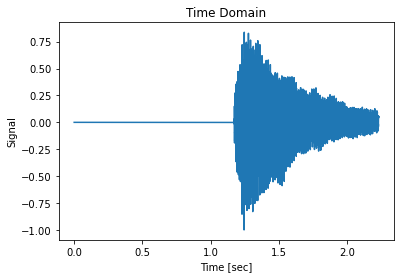

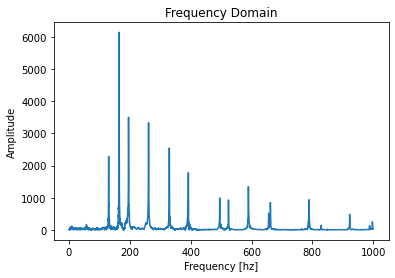

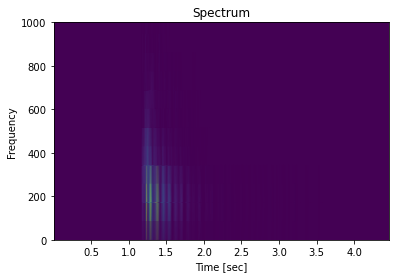

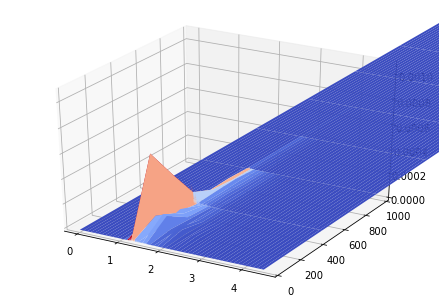

In [13]:
n = 3 # How many notes you want to recognize in the chord.
chord = detect_frequency(filename, n)
notes = specify_chord(chord, n)
plot_the_chord(filename, notes)

In [14]:
print_result(notes)

Detected 3 notes in the chord.
EN3 with frequency: 164.810000
CN3 with frequency: 130.810000
GN3 with frequency: 196.000000
